In [1]:
from datasets import (
    Dataset,
    load_from_disk,
    concatenate_datasets,
)
from konlpy.tag import Mecab, Kkma
from rank_bm25 import BM25Okapi

In [2]:
org_dataset = load_from_disk("/opt/ml/input/data/train_dataset")
full_ds = concatenate_datasets(
    [
        org_dataset["train"].flatten_indices(),
        org_dataset["validation"].flatten_indices(),
    ]
) # train dev 를 합친 4192 개 질문에 대해 모두 테스트
print("*"*40, "query dataset", "*"*40)
print(full_ds)
full_ds[1]

Loading cached processed dataset at /opt/ml/input/data/train_dataset/train/cache-5864ec783ab77348.arrow
Loading cached processed dataset at /opt/ml/input/data/train_dataset/validation/cache-ec5c6075463087d0.arrow


**************************************** query dataset ****************************************
Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 4192
})


{'__index_level_0__': 2873,
 'answers': {'answer_start': [212], 'text': ['《경영의 실제》']},
 'context': "'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 1950년대이다. 2차 세계대전을 마치고, 6.25전쟁의 시기로 유럽은 전후 재건에 집중하고, 유럽 제국주의의 식민지가 독립하여 아프리카, 아시아, 아메리카 대륙에서 신생국가가 형성되는 시기였고, 미국은 전쟁 이후 경제적 변화에 기업이 적응을 해야 하던 시기였다. 특히 1954년 피터 드러커의 저서 《경영의 실제》는 현대적 경영의 기준을 제시하여서, 기존 근대적 인사조직관리를 넘어선 현대적 인사조직관리의 전환점이 된다. 드러커는 경영자의 역할을 강조하며 경영이 현시대 최고의 예술이자 과학이라고 주장하였고 , 이 주장은 21세기 인사조직관리의 역할을 자리매김했다.\\n\\n현대적 인사조직관리와 근대 인사조직관리의 가장 큰 차이는 통합이다. 19세기의 영향을 받던 근대적 경영학(고전적 경영)의 흐름은 기능을 강조하였지만, 1950년대 이후의 현대 경영학은 통합을 강조하였다. 기능이 분화된 '기계적인 기업조직' 이해에서 다양한 기능을 인사조직관리의 목적, 경영의 목적을 위해서 다양한 분야를 통합하여 '유기적 기업 조직' 이해로 전환되었다. 이 통합적 접근방식은 과정, 시스템, 상황을 중심으로 하는 인사조직관리 방식을 형성했다.",
 'document_id': 51638,
 'id': 'mrc-0-004397',
 'question': '현대적 인사조직관리의 시발점이 된 책은?',
 'title': '인사조직관리'}

In [3]:
# org_dataset["validation"]['title']

In [4]:
mecab = Mecab()
def tokenize(text):
    # return text.split(" ")
    return mecab.morphs(text)

# kkma = Kkma()
# def tokenize_kkma(text):
#     return kkma.morphs(text)

In [5]:
# 사용할 stopwords 저장
with open("code/sparse-mecab-koreanwiki/stopwords.txt", "r") as f:
    stopwords = f.readlines()
stopwords = [x.split("\n")[0] for x in stopwords]

# Stopwords 를 제거해주는 함수
# 문서를 tokenize 한 후 BM25 점수 계산 전에 적용해주세요
def remove_stop(tok):
    return [x for x in tok if x.strip() not in stopwords]


# 질문에 특정적인 용어를 삭제하는 함수
def remove_q(query):
    stop = "|".join(
        "어느 무엇인가요 무엇 누가 누구인가요 누구인가 누구 어디에서 어디에 어디서 어디인가요 어디를 어디 언제 어떤 어떠한 몇 얼마 얼마나 뭐 어떻게 무슨 \?".split(
            " "
        )
    )
    rm = re.sub(stop, "", query).strip()
    return rm


# Retriever 에서 사용되는 토크나이저
def process_morphs_simple(query):
    rm = remove_q(query)
    pos = mecab.pos(rm)
    return [x[0] for x in pos if x[1][0] != "J" and x[1][0] != "E" and x[1][0] != "X"]

In [6]:
import os, json

data_path="code/sparse-mecab-koreanwiki/"
context_path="wikipedia_documents_kor_v3.json"

with open(os.path.join(data_path, context_path), "r") as f:
            wiki = json.load(f)

contexts = [v['text'] for v in wiki.values()] # set 은 매번 순서가 바뀌므로
document_ids = [v['document_id'] for v in wiki.values()] # set 은 매번 순서가 바뀌므로
# contexts[13650]

In [7]:
print(len(contexts), len(document_ids))

60045 60045


In [8]:
tokenized_corpus = [remove_stop(tokenize(doc)) for doc in contexts]
bm25 = BM25Okapi(tokenized_corpus)

In [14]:
from tqdm import tqdm
import re
import numpy as np

count = [0, 0, 0, 0, 0]
topk = [1, 3, 5, 10, 20]
check = []

# Retriever class init 시 아래와 같이 저장해둡니다
# id2context = {
#             sample["document_id"]: sample["text"] for sample in original_wiki.values()
#         }


# context2id = {
#            sample["text"] : sample["document_id"] for sample in original_wiki.values()
#         }


# retrieval 함수 내에서 아래와 같이 사용
# tmp["original_context"] = self.id2context[example["document_id"]]


# for i in range(4):
for j in tqdm(range(len(full_ds))):
    query = full_ds['question'][j]
    ground_truth = full_ds['document_id'][j]
    
    result = bm25.get_scores(process_morphs_simple(query))
#     print(result.shape)
#     exit()
    sorted_result = np.argsort(result.squeeze())[::-1]
            
    doc_scores, doc_indices = result.squeeze()[sorted_result].tolist()[:20], sorted_result.tolist()[:20]
    
#     print(doc_scores)
#     print(doc_indices)
#     topk_contexts = bm25.get_top_n(process_morphs_simple(query), contexts, n=20)
#     bm25_candidate = BM25Okapi([tokenize(doc) for doc in topk_contexts])
#     topk_contexts = bm25_candidate.get_top_n(tokenize(query), topk_contexts, n=20)

    for idx in range(20):
#         print(doc_indices[idx])
        if document_ids[doc_indices[idx]] == ground_truth:
            check.append(idx)
            if idx == 0:
                count[0] += 1
            elif 0 < idx < 3:
                count[1] += 1
            elif 0 < idx < 5:
                count[2] += 1
            elif 5 < idx < 10:
                count[3] += 1
            elif 10 < idx < 20:
                count[4] += 1
#             exit()
            break

count[4] += (count[0] + count[1] + count[2] + count[3])
count[3] += (count[0] + count[1] + count[2])
count[2] += (count[0] + count[1])
count[1] += count[0]

100%|██████████| 4192/4192 [16:40<00:00,  4.19it/s]


In [15]:
print(count)
print(np.array(count) / len(full_ds))

[2541, 3355, 3540, 3655, 3774]
[0.60615458 0.80033397 0.84446565 0.87189885 0.90028626]


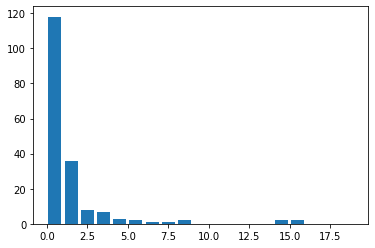

In [11]:
# !pip install matplotlib

import matplotlib.pyplot as plt

plt.hist(check, rwidth=0.8, bins=np.arange(0,20,1))
plt.show()

In [12]:
from tqdm import tqdm

count_kkma = [0, 0, 0, 0, 0]
topk_kkma = [1, 3, 5, 10, 20]
check_kkma = []

# for i in range(4):
for j in tqdm(range(len(full_ds))):
    query = full_ds['question'][j]
    ground_truth = full_ds['context'][j]
    topk_contexts = bm25.get_top_n(tokenize_kkma(query), contexts, n=20)
    for idx, text in enumerate(topk_contexts):
        if text == ground_truth:
            check_kkma.append(idx)
            if idx == 0:
                count_kkma[0] += 1
            elif 0 < idx < 3:
                count_kkma[1] += 1
            elif 0 < idx < 5:
                count_kkma[2] += 1
            elif 5 < idx < 10:
                count_kkma[3] += 1
            elif 10 < idx < 20:
                count_kkma[4] += 1
            continue

count_kkma[4] += (count_kkma[0] + count_kkma[1] + count_kkma[2] + count_kkma[3])
count_kkma[3] += (count_kkma[0] + count_kkma[1] + count_kkma[2])
count_kkma[2] += (count_kkma[0] + count_kkma[1])
count_kkma[1] += count_kkma[0]

  0%|          | 0/4192 [00:00<?, ?it/s]


NameError: name 'tokenize_kkma' is not defined

In [ ]:
import numpy as np

print(count_kkma)
print(np.array(count_kkma) / len(full_ds))

In [ ]:
# !pip install matplotlib

import matplotlib.pyplot as plt

plt.hist(check_kkma, rwidth=0.8, bins=np.arange(0,20,1))
plt.show()

#### 